# Creating records 
## Pipeline 2.0
##### ASTROMER dev team

*Feb 27 2024*

In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import numpy as np
import os

from src.data.record import DataPipeline, create_config_toml

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

%load_ext autoreload
%autoreload 2

2024-06-25 04:54:39.207908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Describing raw data before record creation

In [5]:
metadata = pl.read_parquet('./data/praw/alcock/metadata.parquet')
single_md = metadata.filter(pl.col('shard') == 0)
observations = pl.read_parquet('./data/praw/alcock/light_curves/shard_000.parquet')
observations.columns

['mjd', 'mag', 'errmag', 'newID', '__index_level_0__']

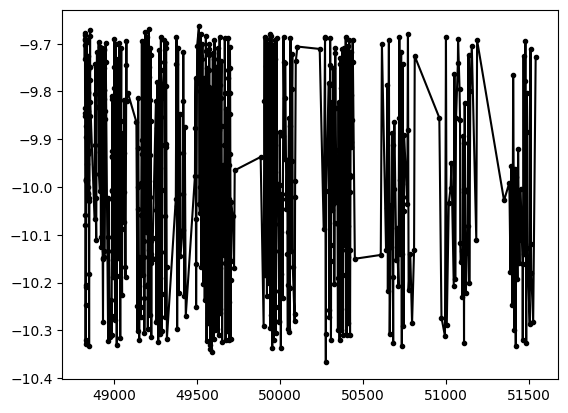

In [6]:
fig, axes = plt.subplots(1, 1)
curve = observations.filter(pl.col('newID') == 1)
axes.plot(curve['mjd'], curve['mag'], marker='.', color='k')
plt.show()

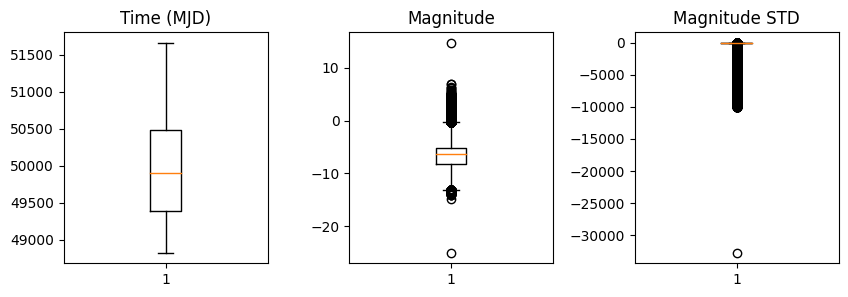

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'wspace':0.4}, dpi=100)
axes[0].boxplot(observations['mjd'])
axes[0].set_title('Time (MJD)')
axes[1].boxplot(observations['mag'])
axes[1].set_title('Magnitude')
axes[2].boxplot(observations['errmag'])
axes[2].set_title('Magnitude STD')
plt.show()

## Creating records

In order to specify record features you have to create a `config.toml` file. A template of the config file is as following: 

```
[id_column]
    value = 'newID'
    dtype = 'integer'  
    
[target]
    value = './data/records_parquet/alcock'
    dtype = 'string' 

[context_features]
	value = ['ID', 'Label', 'Class', 'Band']
	dtypes = ['string', 'integer', 'string', 'integer']

[sequential_features]
	value = ['mjd', 'mag', 'err']
	dtypes = ['float', 'float', 'float']
```

where `newID` is an integer-based id used for efficently filter light curves. `general.target` specifies the target directory where tf.records will be stored. `context_features` are the columns from the `metadata.csv` containing static information of the light curve while `sequential_features` are the time-depended features. The name of the columns both for context and sequential features should match the names of the column in their corresponding tables (`metadata.csv` and `lightcurves/shard_xxx.parquet`).

In [10]:
METAPATH = './data/praw/ogle/metadata.parquet'
OBSPATH  = './data/praw/ogle/light_curves/'

In [11]:
metadata = pd.read_parquet(METAPATH)

In [14]:
metadata.sample(1)

,ID,Class,Path,N,Band,sset,newID,path,Label,shard
282009,OGLE-BLG-LPV-146917,OSARG,OGLE-BLG-LPV-146917.dat,1313,1.0,train,282009,data/raw_data/ogle/LCs/OGLE-BLG-LPV-146917.dat,4,14


use `create_config_toml` to easily create a config file

In [19]:
create_config_toml(parquet_id='newID',
                   target='./data/precords/alcock/',
                   context_features=['ID', 'Class', 'N', 'Band', 'Label', 'shard'],
                   sequential_features=['mjd', 'mag', 'errmag'],
                   context_dtypes=['string', 'string', 'integer', 'integer', 'integer', 'integer'],
                   sequential_dtypes=['float', 'float', 'float'])

[INFO] Toml file succefully created at: ./data/precords/alcock/


In [20]:
metadata.sample()

,ID,Class,Path,N,Band,sset,newID,path,Label,shard
60274,lmc_sc3_i_225502,std,lmc_sc3_i_225502.dat,366,1.0,train,60274,data/raw_data/ogle/LCs/lmc_sc3_i_225502.dat,10,3


### Using DataPipeline class

We first define our train-test-validation subsets using the `ID`

In [21]:
test_metadata = metadata.sample(frac=0.25)
rest = metadata[~metadata['newID'].isin(test_metadata['newID'])]
assert test_metadata['newID'].isin(rest['newID']).sum() == 0 # check if there are duplicated indices

validation_metadata = rest.sample(frac=0.25)
train_metadata = rest[~rest['newID'].isin(validation_metadata['newID'])]
assert train_metadata['newID'].isin(validation_metadata['newID']).sum() == 0 # check if there are duplicated indices

it is important to define a new column in metadata with the `subset_k` tag, where `k` is the number of the fold. You can create as many folds as you want while creating more `subset` columns.

In [22]:
train_metadata['subset_0'] = ['train']*train_metadata.shape[0]
validation_metadata['subset_0'] = ['validation']*validation_metadata.shape[0]
test_metadata['subset_0'] = ['test']*test_metadata.shape[0]

/tmp/ipykernel_3161754/2469551710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_metadata['subset_0'] = ['train']*train_metadata.shape[0]


After having all defined we create our final metadata:

In [23]:
final_metadata = pd.concat([train_metadata, validation_metadata, test_metadata])
final_metadata['subset_0'].unique()

array(['train', 'validation', 'test'], dtype=object)

once everything is ready in our metadata csv we can start using the `DataPipeline` class

In [26]:
# Create an instance of DataPipeline
config_path = './data/precords/alcock/config.toml'

pipeline = DataPipeline(metadata=final_metadata,
                        config_path=config_path)

[INFO] 393103 samples loaded


In [27]:
pipeline.metadata.sample(4)

,ID,Class,Path,N,Band,sset,newID,path,Label,shard,subset_0
237188,OGLE-BLG-LPV-168245,OSARG,OGLE-BLG-LPV-168245.dat,1683,1.0,train,237188,data/raw_data/ogle/LCs/OGLE-BLG-LPV-168245.dat,4,11,test
217956,OGLE-BLG-RRLYR-08479,RRab,OGLE-BLG-RRLYR-08479.dat,330,1.0,train,217956,data/raw_data/ogle/LCs/OGLE-BLG-RRLYR-08479.dat,5,10,train
62800,lmc_sc7_i_303828,std,lmc_sc7_i_303828.dat,377,1.0,train,62800,data/raw_data/ogle/LCs/lmc_sc7_i_303828.dat,10,3,train
288616,OGLE-BLG-LPV-086168,OSARG,OGLE-BLG-LPV-086168.dat,823,1.0,train,288616,data/raw_data/ogle/LCs/OGLE-BLG-LPV-086168.dat,4,14,test


In [28]:
for k in range(1):
    train_subset = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'train']
    val_subset   = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'validation']
    test_subset  = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'test']

    print(train_subset.shape, val_subset.shape, test_subset.shape)

    print('test in train?: ', test_subset['ID'].isin(train_subset['ID']).all(),'\n',
          'val in train?: ', val_subset['ID'].isin(train_subset['ID']).all(),'\n',
          'val in test?: ', val_subset['ID'].isin(test_subset['ID']).all())

(221120, 11) (73707, 11) (98276, 11)
test in train?:  False 
 val in train?:  False 
 val in test?:  False


Now it is **time to the pipeline**

In [29]:
pipeline.context_features, pipeline.context_features_dtype

(['ID', 'Class', 'N', 'Band', 'Label', 'shard'],
 ['string', 'string', 'integer', 'integer', 'integer', 'integer'])

In [30]:
%%time
var = pipeline.run(observations_path=OBSPATH, 
                   n_jobs=8,
                   elements_per_shard=20000)

2024-06-25 05:00:00,480 - INFO - Starting DataPipeline operations


[INFO] Reading parquet
[INFO] Light curves loaded


Processing fold 1/1 - train:   0%|                                                                                                          | 0/3 [00:00<?, ?it/s]2024-06-25 05:01:08.986890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-25 05:01:08.987231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-25 05:01:08.987517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-25 05:01:08.987799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS h

Processing fold 1/1 - test: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:23<00:00, 87.78s/it]
2024-06-25 05:05:31,495 - INFO - Finished execution of DataPipeline operations


CPU times: user 35min 34s, sys: 4min 14s, total: 39min 49s
Wall time: 5min 31s


### Customize what happens within the preprocess function

You must keep the same parameters of the method i.e., `row, context_features, sequential_features`. 

Also the **output** should be tuple containing the lightcurve (`pd.DataFrame`) and the context values (`dict`)


To modify the `process_sample` method we need to create a new class (`MyPipeline`) that inherits from `DataPipeline` 

polars functions: https://docs.pola.rs/api/python/stable/reference/expressions/functions.html

In [31]:
import polars as pl
class MyPipeline(DataPipeline):
    def lightcurve_step(self, inputs):
        """
        Preprocessing applied to each light curve separately
        """
        # First feature is time
        inputs = inputs.sort(self.sequential_features[0], descending=True) 
        p99 = inputs.quantile(0.95, 'nearest')
        p01 = inputs.quantile(0.05, 'nearest')
        inputs = inputs.filter(pl.col('mag') < p99['mag'])
        inputs = inputs.filter(pl.col('mag') > p01['mag'])
        return inputs

    def observations_step(self):
        """
        Preprocessing applied to all observations. Filter only
        """
        fn_0 = pl.col('errmag') > 0
        fn_1 = pl.col('errmag') < 1.
        fn_2 = pl.col('errmag') < pl.col('mag').abs()
        return fn_0 & fn_1 & fn_2

Next steps are the same as using the original `DataPipeline` class

In [32]:
custom_pipeline = MyPipeline(metadata=final_metadata,
                             config_path=config_path)

[INFO] 393103 samples loaded


In [33]:
%%time
var = custom_pipeline.run(observations_path=OBSPATH, 
                          n_jobs=10,
                          elements_per_shard=20000)

2024-06-25 05:06:29,511 - INFO - Starting DataPipeline operations


[INFO] Reading parquet
[INFO] Light curves loaded


Processing fold 1/1 - test: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:03<00:00, 81.22s/it]
2024-06-25 05:14:32,142 - INFO - Finished execution of DataPipeline operations


CPU times: user 2h 4min 22s, sys: 11min 24s, total: 2h 15min 46s
Wall time: 8min 2s


# Reading

In [34]:
import tensorflow as tf
from src.data.loaders import get_loader
from src.data.zero import pretraining_pipeline # astromer v0
import glob
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
root = './data/precords/alcock/fold_0/train/'
window_size = 200
probed_frac = .2
random_frac = 0.
same_frac = 0.

In [36]:
dataset = get_loader(root, 
                     window_size=window_size,
                     batch_size=2,
                     probed_frac=probed_frac,
                     random_frac=random_frac,
                     same_frac=same_frac,
                     shuffle=True,
                     sampling=False,
                     aversion='base',
                     normalize='zero-mean',
                     cache=True)

[INFO] Probed: 0.20 Random: 0.00 Same: 0.00
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-06-25 05:14:47,582 - WARNING - From /usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/pyct/static_analysis/liveness.py:83: Analyzer.lamba_check (from tensorflow.python.autograph.pyct.static_analysis.liveness) is deprecated and will be removed after 2023-09-23.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Cache activated


2024-06-25 05:15:00.648588: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


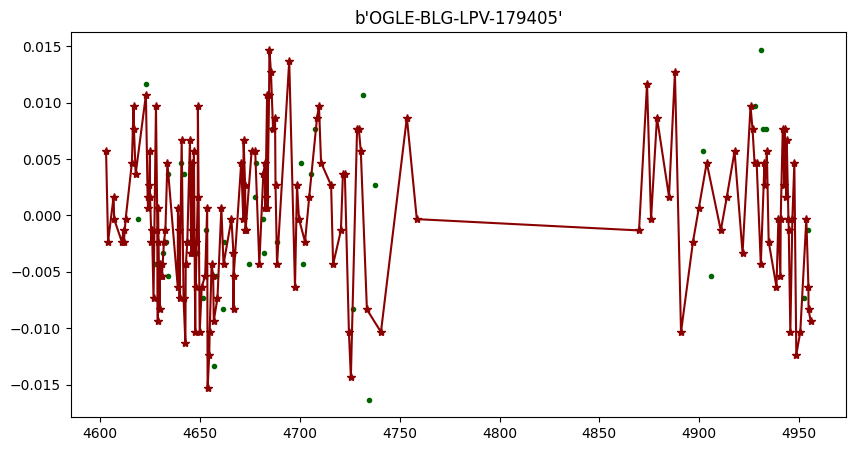

In [37]:
plt.figure(figsize=(10, 5))
for x, y in dataset.take(1):
    plt.title(y['lcid'][0].numpy())
    xinp = tf.boolean_mask(x['input'][0], 1.-x['mask_in'][0])
    tinp = tf.boolean_mask(x['times'][0], 1.-x['mask_in'][0])
    
    xinp_2 = tf.boolean_mask(x['input'][0], y['mask_out'][0])
    tinp_2 = tf.boolean_mask(x['times'][0], y['mask_out'][0])
    plt.plot(tinp_2, xinp_2, marker='.', linestyle='', color='darkgreen')
    plt.plot(tinp, xinp, marker='*', linestyle='-', color='darkred')
    
    